In [1]:
#conda install -c conda-forge fbprophet -y

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

plt.style.use('default')

In [3]:
data = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\Forecast Gold Price\Gold_data.csv")
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
print("Number of rows and columns:", data.shape)
data.head()

Number of rows and columns: (2182, 2)


,date,price
0,2016-01-01,2252.60
1,2016-01-02,2454.50
2,2016-01-03,2708.10
3,2016-01-04,2577.80
4,2016-01-05,2597.75


In [4]:
data.tail()

,date,price
2177,2021-12-17,4394.4
2178,2021-12-18,4389.5
2179,2021-12-19,4389.5
2180,2021-12-20,4354.1
2181,2021-12-21,4346.5


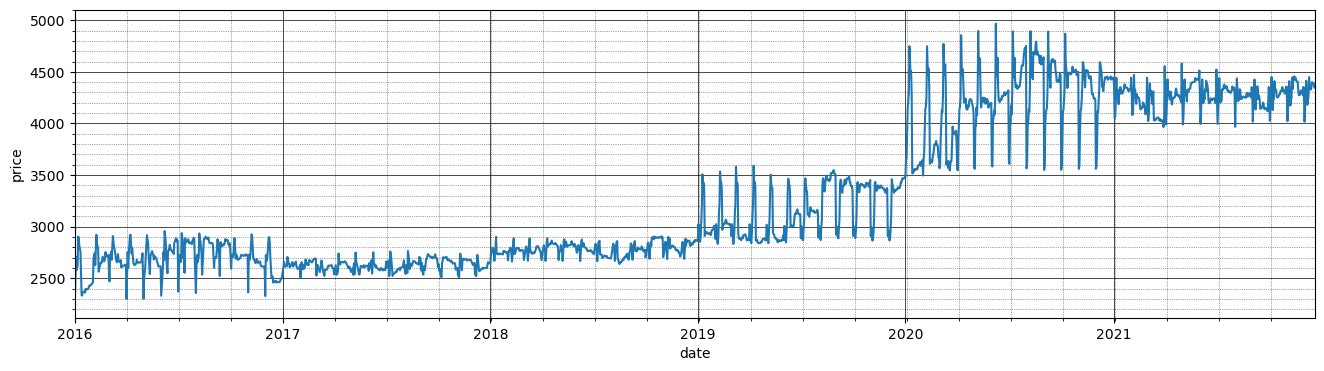

In [5]:
f, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(data=data, x="date", y="price")

ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth=0.5, color='black',)
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black', alpha=0.7)

ax.set_xlim([datetime(2016,1,1), datetime(2021,12,21)]);

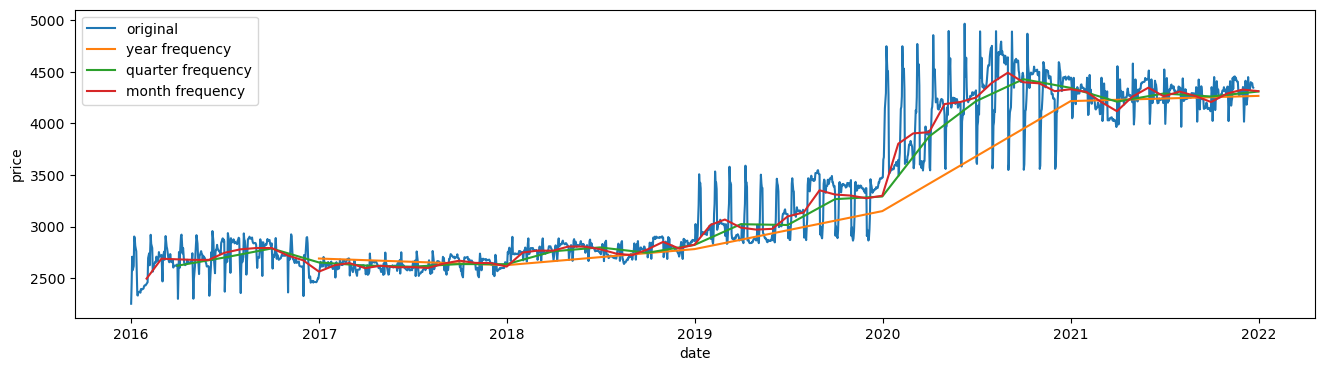

In [6]:
f, ax = plt.subplots(figsize=(16, 4))
data_resample_y = data.resample(rule='Y', on='date').mean()
data_resample_m = data.resample(rule='M', on='date').mean()
data_resample_q = data.resample(rule='Q', on='date').mean()

sns.lineplot(data=data, x="date", y="price", label="original")
sns.lineplot(data=data_resample_y, x="date", y="price", label="year frequency")
sns.lineplot(data=data_resample_q, x="date", y="price", label="quarter frequency")
sns.lineplot(data=data_resample_m, x="date", y="price", label="month frequency");

# 1. Hodrick-Prescott filter

### The HP filter is commonly applied during analysis to remove short-term fluctuations associated with the business cycle. Removal of these short-term fluctuations reveals long-term trends.

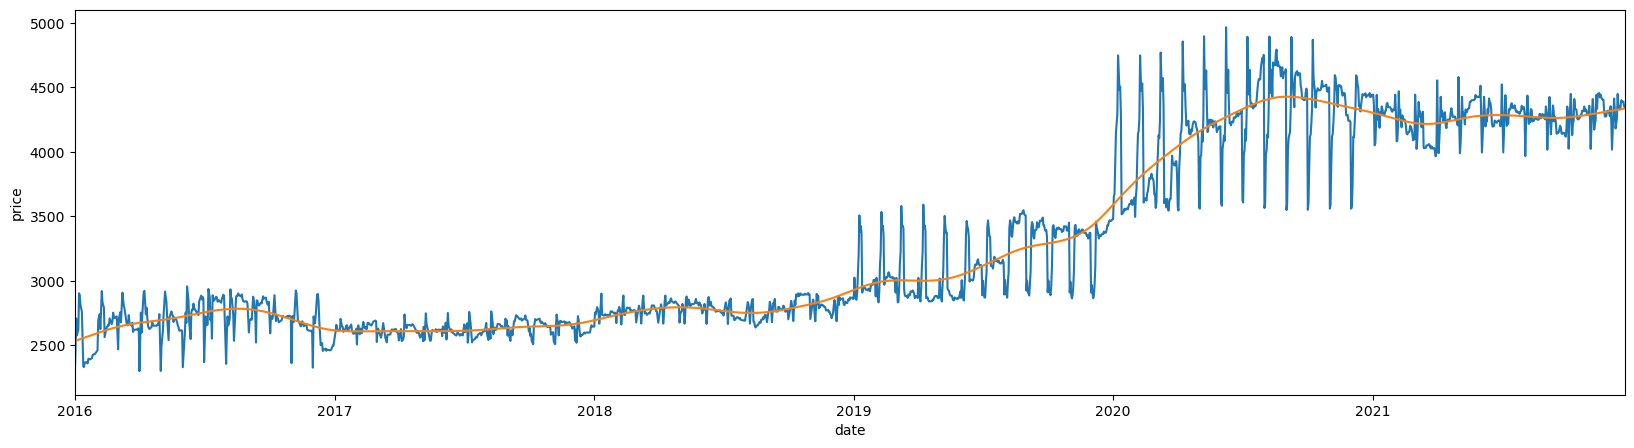

In [7]:
from statsmodels.tsa.filters.hp_filter import hpfilter

cycle, trend = hpfilter(data['price'], lamb=1296000)

f, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=data, x="date", y="price")
sns.lineplot(x=data['date'], y=trend.to_list())

ax.set_xlim([datetime(2016,1,1), datetime(2021,12,21)]);

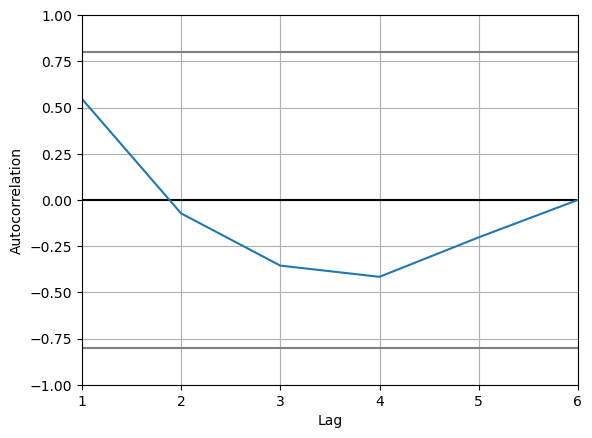

In [8]:
pd.plotting.autocorrelation_plot(data_resample_y);

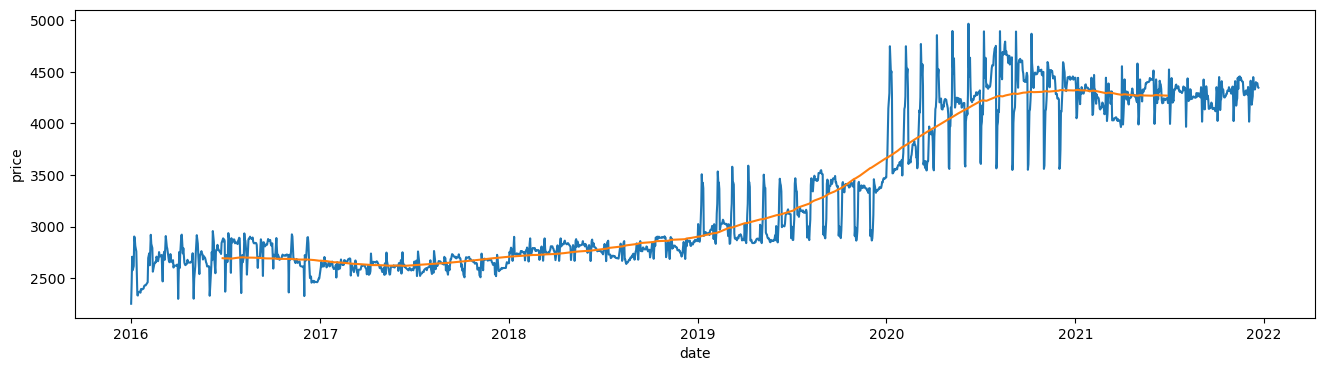

In [9]:
f, ax = plt.subplots(figsize=(16, 4))
data_rolling = data.rolling(365, center=True, min_periods=360).mean()

sns.lineplot(data=data, x="date", y="price")
sns.lineplot(data=data, x="date", y=data_rolling["price"]);

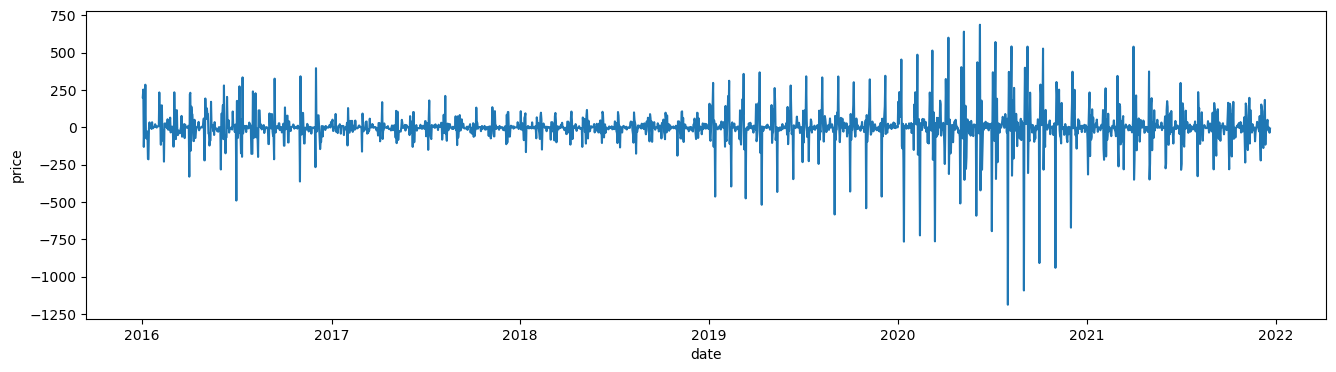

In [10]:
data_diff=data.diff().dropna()

fig = plt.figure(figsize = (16,4))
sns.lineplot(x=data["date"], y=data_diff["price"]);

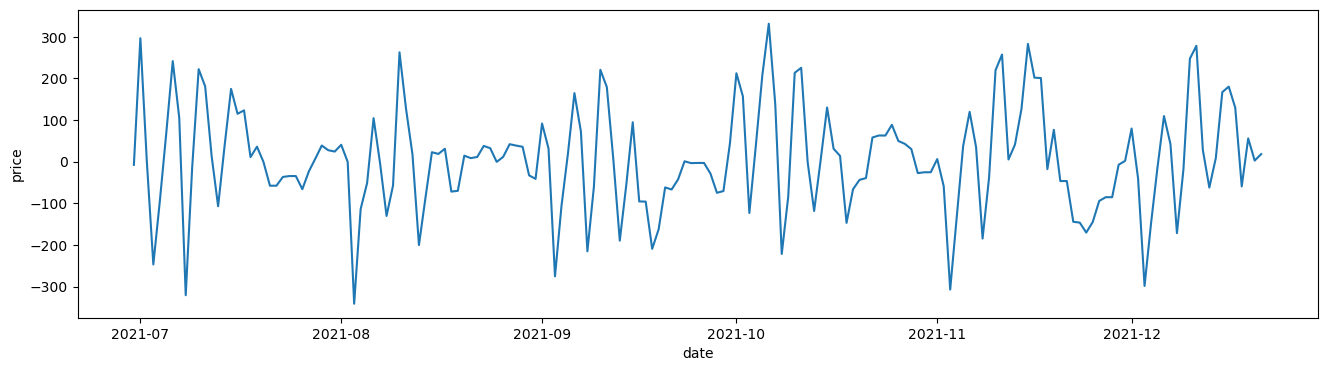

In [11]:
data_diff_sample=data[2000:2500].diff(axis = 0, periods = 7).dropna()

fig = plt.figure(figsize = (16,4))
sns.lineplot(x=data["date"][2000:2500], y=data_diff_sample["price"]);

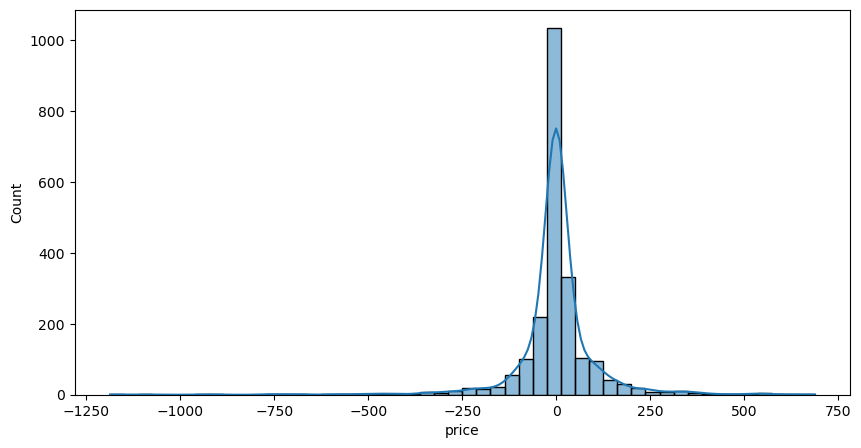

In [12]:
fig = plt.figure(figsize = (10,5))
sns.histplot(data_diff["price"], bins=50, kde=True);
# sns.kdeplot(data_diff["Value"]);

# 2. Augmented Dickey-Fuller test

### Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not.

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_diff["price"])

print(f'ADF Statistic: {result[0]:.3f}')
print(f'p-value: {result[1]:.3f}')

for key, value in result[4].items():
    print(f'Critical values({key}): {value:.3f}')
    
if result[0]<result[4]['1%']:
    print("Dataset is stationary!")
    


stat, p, lags, obs, crit, t = adfuller(data_diff["price"])
print(f'stat: {stat:.5f}\np-value: {p:.5f}')

if p > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

ADF Statistic: -21.665
p-value: 0.000
Critical values(1%): -3.433
Critical values(5%): -2.863
Critical values(10%): -2.567
Dataset is stationary!
stat: -21.66454
p-value: 0.00000
Probably Stationary


### The given Time series is stationary

# 3. Kwiatkowski-Phillips-Schmidt-Shin¶

### KPSS test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root. A stationary time series is one where statistical properties — like the mean and variance — are constant over time.

In [14]:
from statsmodels.tsa.stattools import kpss

stat, p, lags, crit = kpss(data_diff["price"])
print(f'stat: {stat:.5f}\np-value: {p:.5f}')

if p > 0.05:
    print('Probably not Stationary')
else:
    print('Probably Stationary')

stat: 0.01776
p-value: 0.10000
Probably not Stationary


C:\Users\hp\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# 4. Order of differencing (d)

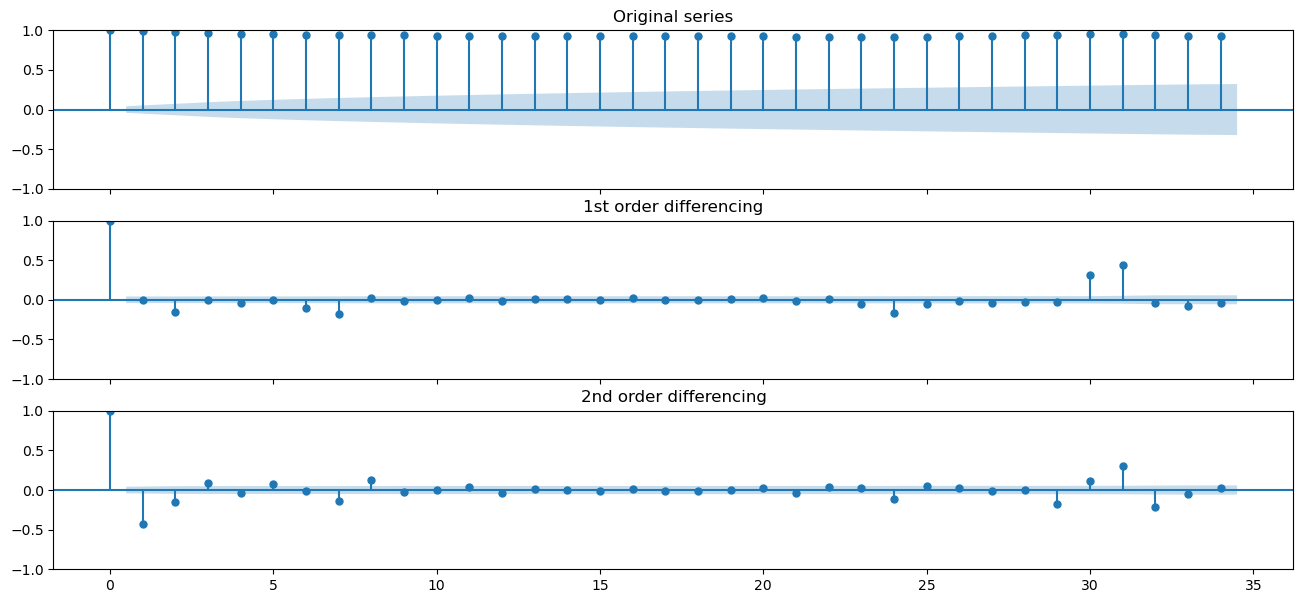

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 1, sharex=True, figsize = (16,7))

plot_acf(data["price"], ax=axes[0])
axes[0].set_title('Original series')

plot_acf(data["price"].diff().dropna(), ax=axes[1])
axes[1].set_title('1st order differencing')

plot_acf(data["price"].diff().diff().dropna(), ax=axes[2])
axes[2].set_title('2nd order differencing');

### Lags in 2nd differencing fall into negative zone very quickly, indicating the series may have been over differenced. Thus, 1st differencing should be chosen.

In [16]:
#!pip install pmdarima

In [17]:
from pmdarima.arima.utils import ndiffs

print(f"ADF Test: {ndiffs(data['price'], test='adf')}")
print(f"KPSS test: {ndiffs(data['price'], test='kpss')}")
print(f"PP test: {ndiffs(data['price'], test='pp')}")

ADF Test: 0
KPSS test: 1
PP test: 0


# 5. Order of AR term (p)

### Method of finding p
### - Partial Autocorrelation (PACF) plot
### * correlation between the series and its lag excluding the contributions from the intermediate lags

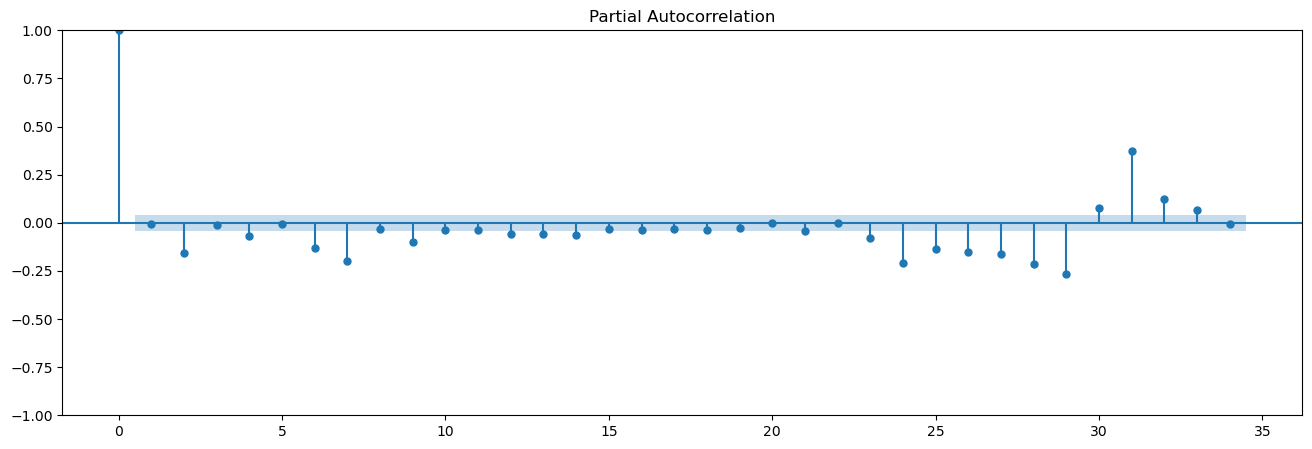

In [18]:
from pylab import rcParams

rcParams['figure.figsize'] = 16,5
plot_pacf(data["price"].diff().dropna())
plt.show()

### The result of AR, lag 1 is also far above the significance line than others.

# 6. Order of MA term (q)
### - Definition of MA term (q):
### - error of the lagged forecast
### - Method of finding q
### - ACF
### * show no of MA terms required to remove autocorrelation in a stationarized series

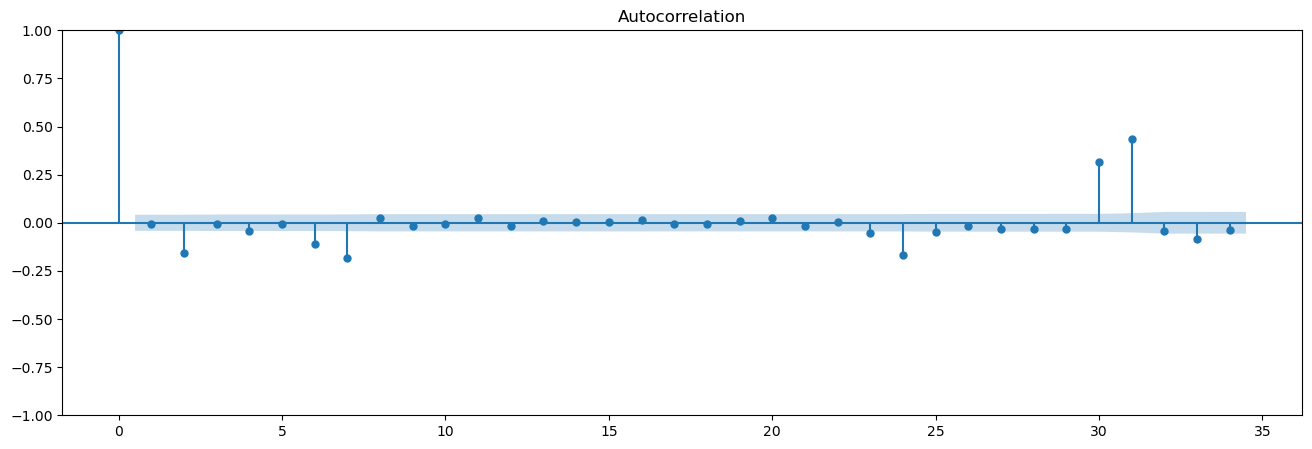

In [19]:
rcParams['figure.figsize'] = 16,5
plot_acf(data["price"].diff().dropna())
plt.show()

### Similar with the result of AR, lag 1 is also far above the significance line than others.

### q=1

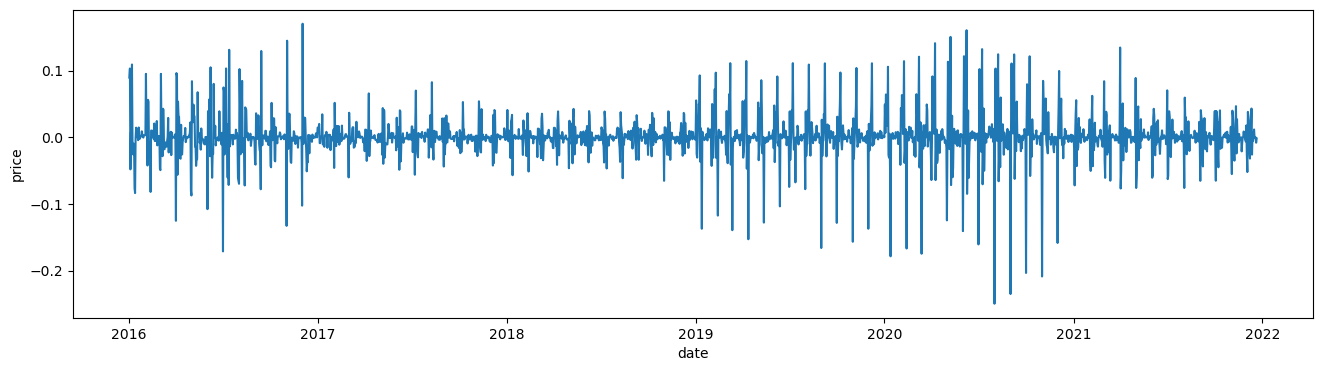

In [20]:
data_change=data["price"].pct_change(periods=1)

fig = plt.figure(figsize = (16,4))
sns.lineplot(x=data["date"], y=data_change);

# 7. Time Series Components
### 3 systematic components: level, trend, seasonality
### 1 non-systematic component: noise

### - Level: average value
### - Trend: increasing/ decreasing value
### - Seasonality: repeating short-term cycle
### - Noise: random variation

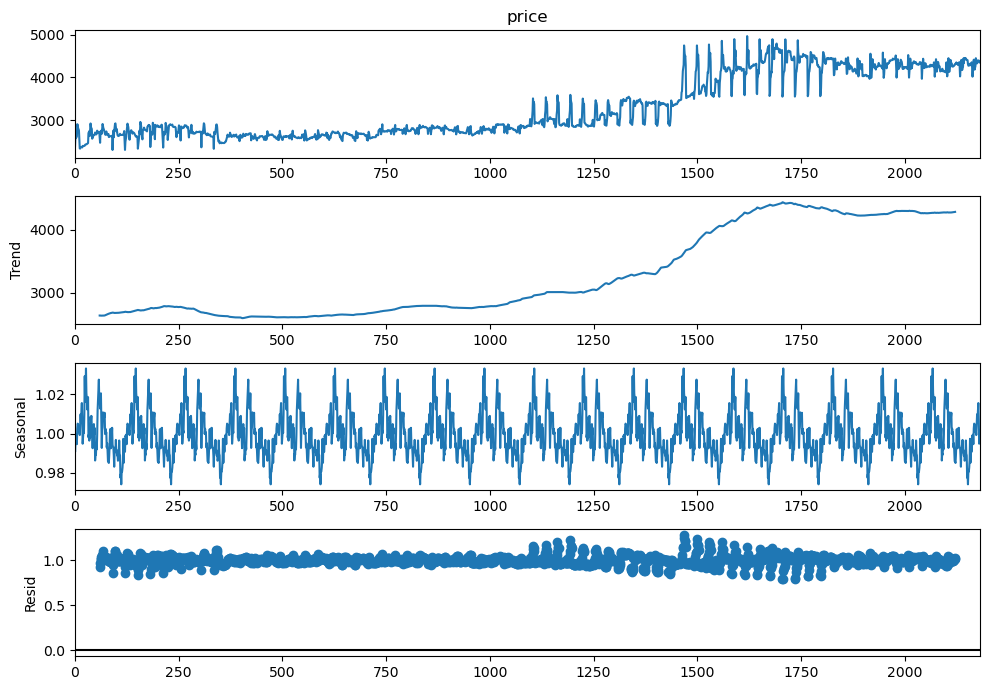

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

result = seasonal_decompose(data['price'], model='multiplicative', period=120)

rcParams['figure.figsize'] = 10,7
result.plot();

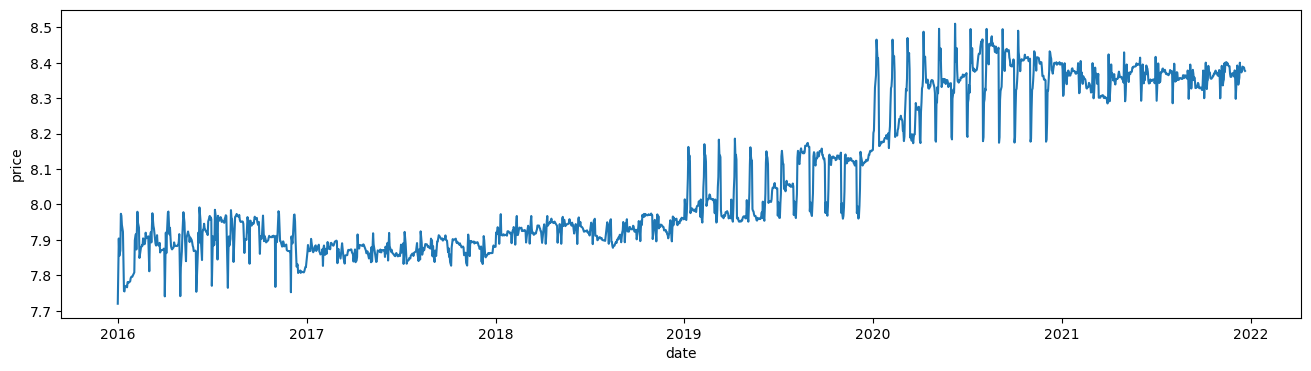

In [22]:
data_log = np.log(data["price"])
fig = plt.figure(figsize = (16,4))
sns.lineplot(x=data["date"], y=data_log);

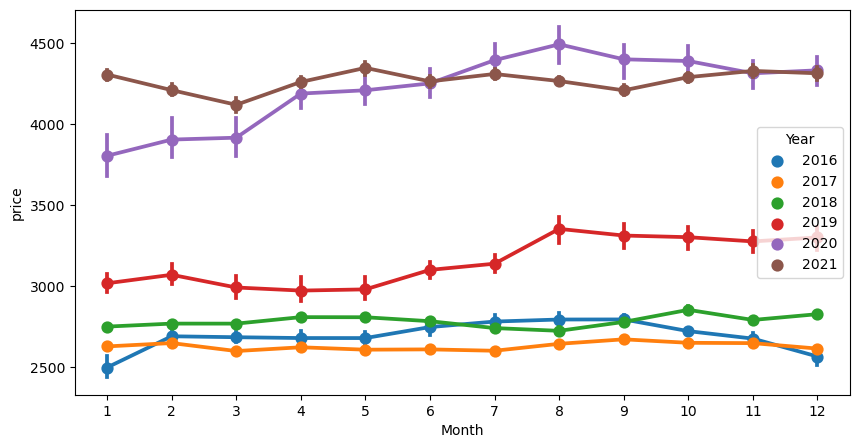

In [23]:
df_temp = data[:2200].copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp['date']).year
df_temp['Month'] = pd.DatetimeIndex(df_temp['date']).month

plt.figure(figsize=(10,5))
sns.pointplot(x='Month', y='price', hue='Year', data=df_temp);

# 8. ARIMA model

### Auto Arima Forecast

In [24]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [30]:
train = data["price"][:1746]
test = data["price"][1746:]

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1746
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10732.501
Date:                Mon, 05 Dec 2022   AIC                          21471.003
Time:                        14:52:02   BIC                          21487.396
Sample:                             0   HQIC                         21477.064
                               - 1746                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6303      0.111     -5.680      0.000      -0.848      -0.413
ma.L1          0.6940      0.106      6.556      0.000       0.487       0.902
sigma2       1.29e+04    125.392    102.885      0.0

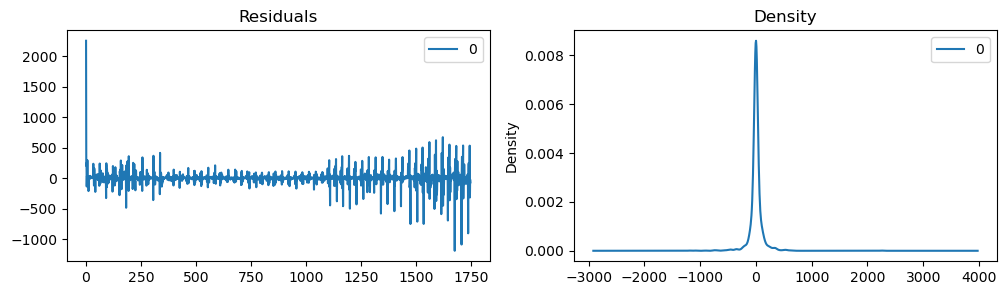

In [31]:
rcParams['figure.figsize'] = 12,3
residuals = pd.DataFrame(model_fit.resid)

fig, ax = plt.subplots(1,2)
residuals.plot(title=
               "Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

## Although residual errors not mainly around zero, but the variance is uniform.

## Note: dynamic=False --> in-sample lagged values are used for prediction

In [32]:
fc, se, conf = model_fit.forecast(steps=3, alpha=0.05)
#arima_predict = model_fit.predict(start=0, end=15000, dynamic=False)

fc_series = pd.Series(fc, index=test.index)

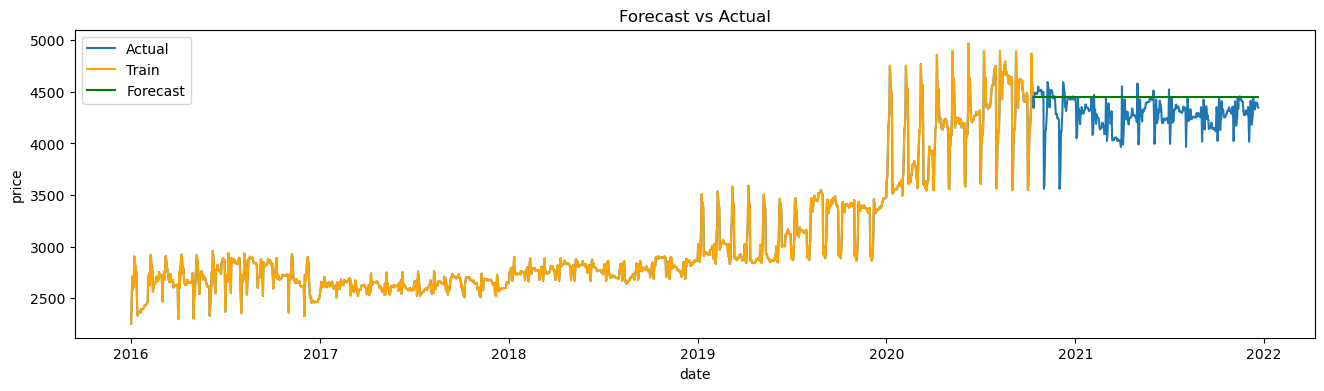

In [33]:
f, ax = plt.subplots(figsize=(16, 4))
plt.title('Forecast vs Actual')
sns.lineplot(data=data, x="date", y="price", label='Actual')
sns.lineplot(data=data, x="date", y=train, color='orange', label='Train')
sns.lineplot(data=data, x="date", y=fc_series, color='g', label='Forecast');
#sns.lineplot(data=data, x="date", y=arima_predict, color='brown', label='Predict');

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [35]:
model = SARIMAX(test, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  436
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2630.430
Date:                Mon, 05 Dec 2022   AIC                           5274.860
Time:                        14:52:04   BIC                           5303.388
Sample:                             0   HQIC                          5286.119
                                - 436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1241      0.149      0.833      0.405      -0.168       0.416
ar.L2         -0.3574      0.183     -1.951      0.051      -0.716       0.002
ar.L3          0.3569      0.138      2.592      0.0

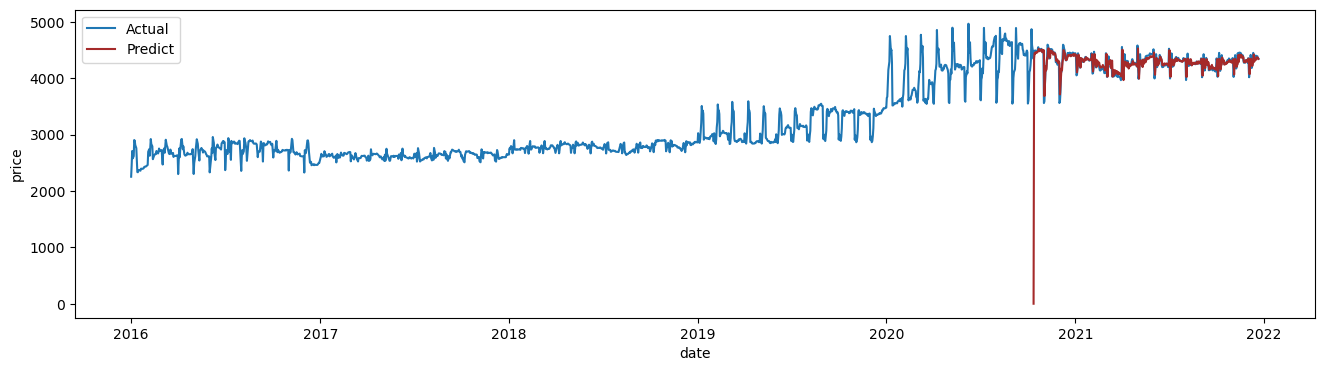

In [36]:
sarimax_predict = model_fit.predict(start=0, end=15000, dynamic=False)

f, ax = plt.subplots(figsize=(16, 4))

sns.lineplot(data=data, x="date", y="price", label='Actual')
sns.lineplot(data=data, x="date", y=sarimax_predict, color='brown', label='Predict');

# RMSE value for ARIMA model

In [37]:
RMSE = np.mean((fc_series - data['price'])**2)**.5
print('RMSE value for ARIMA model is',RMSE)

RMSE value for ARIMA model is 223.8717199881649


In [38]:
# ARIMA(2,1,2) is suggested as it has smallest AIC (Akaike information criterio) value

In [43]:
from sklearn.metrics import mean_squared_error

# 1. Holt-Winters

## Uses exponential smoothing to encode lots of values from the past by computing the combined effects of value, trend and seasonality

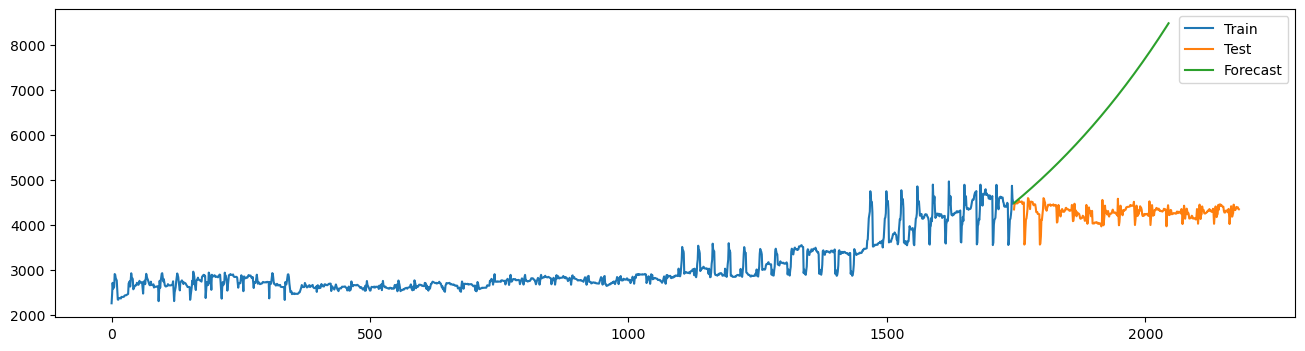

In [40]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train_hw = data["price"][:1746]
test_hw = data["price"][1746:]

future = ExponentialSmoothing(train_hw, trend='mul').fit()
forecast_hw = future.forecast(300)

plt.figure(figsize=(16,4))
plt.plot(train_hw, label='Train')
plt.plot(test_hw, label='Test')
plt.plot(forecast_hw, label='Forecast')
plt.legend(loc='best');

# RMSE value for Holt-Winters model

In [41]:
RMSE = np.mean((forecast_hw - data['price'])**2)**.5
print('RMSE value for Holt-Winters model is',RMSE)

RMSE value for Holt-Winters model is 2316.3339178479587
